# Embedding Vectors

NLP - Spring Semester of 2024 at University of Tehran - CA2

In [ ]:
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split

import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from keras import layers

import re

from tensorflow.keras.preprocessing.sequence import make_sampling_table
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.random import log_uniform_candidate_sampler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Q1

In [100]:
sentiment_df = pd.read_csv('assets/sentiment140.csv', encoding= 'latin_1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
sentiment_df.drop(['ids', 'date', 'flag', 'user'], inplace=True, axis=1)

In [101]:
print(sentiment_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


### Part 1. Choose 5000 samples from each class and do the preprocessing.

In order to sample `n` items from each class, we'll have to first group the dataset by class column and then sample `n` items from each group.

In [102]:
CLASS_COUNT = 5000

sentiment_df = sentiment_df.groupby('target', group_keys=False).apply(lambda x: x.sample(CLASS_COUNT));

C:\Users\sarae\AppData\Local\Temp\ipykernel_25376\2662738067.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentiment_df = sentiment_df.groupby('target', group_keys=False).apply(lambda x: x.sample(CLASS_COUNT));


Before starting the preprocessing, we have to setup the `nltk` library.

In [103]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sarae\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sarae\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


For the preprocessing, we'll first tokenize the tweets by punctuations and white spaces. We'll then remove the stop words, and finally we'll reduce each token to a meaningful base word. The last step is called lemmatization. We can achieve all this with the `nltk` library.

In [104]:
def tokenize_text(tweet: str) -> list[str]:
    """
    This function will first tokenize the tweet based on its punctuations. It'll
    then remove the stop words and lemmatize each token.
    """

    tokens = word_tokenize(tweet)
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.lower() not in punctuations]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

sentiment_df['text_tokenized'] = sentiment_df['text'].apply(tokenize_text)
sentiment_df = sentiment_df[sentiment_df['text_tokenized'].apply(len) > 0]

- `lower()`: This function simply converts all the letters in the given text to lower case. This is useful to unify different forms of the same word.
- `stop_words`: This is a dataset of all the words that are repeated many times in text and doesn't really affect the classification. For example 'the', 'an', or 'from' are some words in this dataset. We ignore every token that is in this dataset to achieve a cleaner and more effective dataset.
- `punctuations`: This is a dataset that contains letters like ',' or '!'. These letters are not very useful in text classification and therefore we ignore them.
- `lemmatizer`: The last step in our preprocessing is to lemmatize each token. We might encounter different forms of the same word. For example 'is', 'am', and 'are' can all be reduced to the form 'be'. Lemmatizer does the exact same thing.

At last, we'll keep 20% of the data for evaluation. We'll use scikit-learn library to split the data. We'll also use the `stratify` parameter to ensure each class gets chosen equally.

In [105]:
train_df, eval_df = train_test_split(sentiment_df, test_size = 0.2, random_state = 42, stratify = sentiment_df['target'])

train_df.reset_index(drop = True, inplace = True)
eval_df.reset_index(drop = True, inplace = True)

In [106]:
vocabulary_set = set().union(*[set(token) for token in train_df['text_tokenized']])
vocabulary = pd.Series(list(vocabulary_set))
vocabulary_index = {word: idx for idx, word in enumerate(vocabulary)}

### Part 2. Create the term frequency matrix for the train dataset.

For this purpose we can easily use the `CountVectorizer` from `sklearn` library.

In [107]:
def count_vectorize(input_tokens: list[str], vocabulary_index: dict[str, int]) -> np.array:
    count_vector = np.zeros((1, len(vocabulary_index)))
    for word in input_tokens:
        index = vocabulary_index.get(word)
        if index is not None:
            count_vector[0, index] += 1
    return count_vector

def get_term_frequency_matrix(docs: pd.Series, vocabulary_index: dict[str, int]) -> np.matrix:
    term_frequency_matrix = np.zeros((len(docs), len(vocabulary_index)))
    for i, doc in enumerate(docs):
        term_frequency_matrix[i] = count_vectorize(doc, vocabulary_index)
    return term_frequency_matrix

term_frequency_matrix = get_term_frequency_matrix(train_df['text_tokenized'], vocabulary_index)

In order to make it more sensible, we can create a data frame out of this matrix with columns having the words as their names.

In [108]:
term_frequency_df = pd.DataFrame(term_frequency_matrix)
term_frequency_df.columns = vocabulary
print(term_frequency_df)

      wah  receibe  forecast  sassenach  party  mucho   ft  knocked  boi  \
0     0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
1     0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
2     0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
3     0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
4     0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
...   ...      ...       ...        ...    ...    ...  ...      ...  ...   
7993  0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
7994  0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
7995  0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
7996  0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   
7997  0.0      0.0       0.0        0.0    0.0    0.0  0.0      0.0  0.0   

      talent  ...  dlead  assessment  c.t  seeing  argh  complex  \
0        0.0  ...  

### Part 3. Create the Tf-idf vector for each sample.

We know that the formulae for tf-idf is what's written below:

$$tf(t, d)\times log(\frac{N}{df + 1})$$

$t$ is the term, $d$ is a document, and $N$ is the number of documents we have in total. In the above formulae $tf(t, d)$ is the frequency of term $t$ in a document $d$. The $df$ is the document frequency, which means the number of occurrences of the term $t$ in the whole document set. <br>
Now let's start by implementing the $tf$.

In [109]:
def tf(docs: pd.Series, vocab: pd.Series) -> np.matrix:
    vocab_idx_map = {value: index for index, value in enumerate(vocab)}
    oov_idx = len(vocab)

    tf_matrix = np.zeros((len(docs), len(vocab) + 1), dtype = float)

    for i, doc in enumerate(docs):
        for term in doc:
            term_idx = 0
            try:
                term_idx = vocab_idx_map[term]
            except:
                term_idx = oov_idx

            tf_matrix[i, term_idx] += 1
    
    tf_matrix = tf_matrix / np.sum(tf_matrix, axis = 1, keepdims=True)
    return tf_matrix

Note that we also have an `oov_idx` which will be used for the words that are not in out vocabulary. In other words, the lat column of the matrix is used for the out of vocabulary words. Next step would be calculating the idf vector.

In [110]:
def idf(docs: pd.Series, vocab: pd.Series) -> np.matrix:
    vocab_idx_map = {value: index for index, value in enumerate(vocab)}
    oov_idx = len(vocab)

    idf_vector = np.zeros((len(vocab) + 1), dtype = float)

    df_vector = np.zeros((len(vocab) + 1), dtype = int)
    for doc in docs:
        for term in set(doc):
            term_idx = 0
            try:
                term_idx = vocab_idx_map[term]
            except:
                term_idx = oov_idx

            df_vector[term_idx] += 1
    
    for i, term in enumerate(vocab):
        idf_vector[i] = np.log(len(docs) / (df_vector[i] + 1))
    
    return idf_vector.T

And in the last step, we'll calculate the tf-idf vector by simply multiplying `tf` matrix with `idf` vector.

In [111]:
def tf_idf(docs: pd.Series, vocab: pd.Series) -> np.matrix:
    tf_matrix = tf(docs, vocab)
    idf_vector = idf(docs, vocab)
    return tf_matrix * idf_vector

In [112]:
tf_idf_matrix = tf_idf(train_df['text_tokenized'], vocabulary)

### Part 4. Calculate the PPMI vector for each sample.

In order to calculate the PPMI vector for each sample, we'll first calculate the PPMI matrix for the whole vocabulary. This will result in a matrix with dimensions of $|V| \times |V|$ for $V$ being the set of vocabulary. After calculating this we'll calculate the average of the target term (Averaging each row of the PPMI matrix over context words) and use it to fill values for each document.<br>
Let's start by calculating the co-occurrence matrix.

In [113]:
CONTEXT_WINDOW_SIZE = 2

def co_occurrence(docs: pd.Series, vocab: pd.Series, window_size = CONTEXT_WINDOW_SIZE) -> np.matrix:
    vocab_idx_map = {value: idx for idx, value in enumerate(vocab)}
    oov_idx = len(vocab)

    co_occurrence_matrix = np.zeros((len(vocab) + 1, len(vocab) + 1), dtype = int)

    for doc in docs:
        for i, term in enumerate(doc):
            target_term_idx = 0
            try:
                target_term_idx = vocab_idx_map[term]
            except:
                target_term_idx = oov_idx

            context_window_start = max(0, i - window_size)
            context_window_end = min(i + window_size, len(vocab))

            for j in range(context_window_start, context_window_end):
                context_term_idx = 0
                try:
                    context_term_idx = vocab_idx_map[vocab[j]]
                except:
                    context_term_idx = oov_idx

                co_occurrence_matrix[target_term_idx, context_term_idx] += 1
    
    return co_occurrence_matrix

Note that we have used the same method as tf_idf to solve the out of vocabulary problem. Now we know that the formulae for PMI is as below:
$$PMI(w_i, w_j) = log_2\left(\frac{P(w_i, w_j)}{P(w_i)\times P(w_j)}\right)$$
The PPMI would be taking the max between 0 and PMI. Let's implement this in a function.

In [114]:
def ppmi(co_occurrence_matrix: np.matrix) -> np.matrix:
    co_occurrence_matrix = co_occurrence_matrix + 1
    total_terms_count = np.sum(co_occurrence_matrix)
    total_targets_occurrences = np.sum(co_occurrence_matrix, axis = 1)
    total_contexts_occurrences = np.sum(co_occurrence_matrix, axis = 0)

    targets_probability = total_targets_occurrences / total_terms_count
    contexts_probability = total_contexts_occurrences / total_terms_count
    co_occurrences_probability = co_occurrence_matrix / total_terms_count

    numerator = co_occurrences_probability
    denominator = np.dot(targets_probability[:, np.newaxis], contexts_probability[np.newaxis, :])
    
    pmi_matrix = np.log2(np.maximum(numerator / denominator, 1e-12))
    ppmi_matrix = np.maximum(pmi_matrix, 0)
    return ppmi_matrix


Now the last step would be getting the average of each target term and use it to calculate the PPMI vector for each tweet.

In [115]:
def doc_ppmi(doc: list[str], ppmi_mean_vector: np.matrix, vocab_idx_map: dict[str, int]) -> np.matrix:
    doc_ppmi_vector = np.zeros((len(vocab_idx_map) + 1), dtype = float)
    for term in doc:
        term_idx = 0
        try:
             term_idx = vocab_idx_map[term]
        except:
             term_idx = len(vocab_idx_map)
        doc_ppmi_vector[term_idx] = ppmi_mean_vector[term_idx]
    return doc_ppmi_vector

def docs_ppmi(docs: pd.Series, vocabulary: pd.Series) -> np.matrix:
    co_occurrence_matrix = co_occurrence(docs, vocabulary)
    ppmi_mean_vector = np.mean(ppmi(co_occurrence_matrix), axis = 1)
    vocab_idx_map = {value: idx for idx, value in enumerate(vocabulary)}
    docs_ppmi_matrix = np.zeros((len(docs), len(vocabulary) + 1))
    for i, tweet in enumerate(docs):
            docs_ppmi_matrix[i, :] = doc_ppmi(tweet, ppmi_mean_vector, vocab_idx_map).reshape(1, -1)
    return docs_ppmi_matrix

### Part 5. Train a Naive Bayes model using each vector and measure their accuracy.

In this section we will first train and test our model, and in the end we'll take a look into the word embedding method that we used.

#### Term Frequency

Let's first prepare the test and train data.

In [117]:
train_tf = get_term_frequency_matrix(train_df['text_tokenized'], vocabulary_index)
eval_tf = get_term_frequency_matrix(eval_df['text_tokenized'], vocabulary_index)

Now, it's time to train our model.

In [118]:
nb_term_freq = MultinomialNB()
nb_term_freq.fit(train_tf, train_df['target'])

MultinomialNB()

And in the last step for this part, we'll calculate the metrics with our evaluation data.

In [119]:
term_freq_y_pred = nb_term_freq.predict(eval_tf)
print(classification_report(eval_df['target'], term_freq_y_pred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1000
           4       0.75      0.66      0.70      1000

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



The term frequency matrix, as the name suggests, predicts labels by seeing what words has occurred in our text. For example, a text that contains the word "fun" more often, is also more probable to be sarcastic than a text that has more "dead"s in it. The problem with this method is that it doesn't consider the context. For example having the word "dying" in "I'm dying of laughter." can make a text more sarcastic than having the word "dying" in "People are dying in war."

#### TF-IDF

In [120]:
train_tf_idf = tf_idf(train_df['text_tokenized'], vocabulary)
eval_tf_idf = tf_idf(eval_df['text_tokenized'], vocabulary)

In [121]:
nb_tf_idf = MultinomialNB()
nb_tf_idf.fit(train_tf_idf, train_df['target'])

MultinomialNB()

In [122]:
tf_idf_y_pred = nb_tf_idf.predict(eval_tf_idf)
print(classification_report(eval_df['target'], tf_idf_y_pred))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1000
           4       0.74      0.64      0.68      1000

    accuracy                           0.70      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.70      0.70      2000



The TF-IDF method works with two parts. The first part is the Term Frequency (TF), which was described in the last section. The second part is the Inverse Document Frequency (IDF). This one says how often does a term appear in our corpus by counting the number of the tweets that contain this term. The rarer a term is, the higher the score become. This method helps us to remove the words that are too common. But if we take a look at the results, we wont see much difference between this and the Term Frequency. The reason behind this is that we removed the stop words in the preprocessing phase and there isn't a lot of common words left to opt out their effect.

#### PPMI

In [123]:
train_ppmi = docs_ppmi(train_df['text_tokenized'], vocabulary)
eval_ppmi = docs_ppmi(eval_df['text_tokenized'], vocabulary)

In [124]:
nb_ppmi = MultinomialNB()
nb_ppmi.fit(train_ppmi, train_df['target'])

MultinomialNB()

In [125]:
ppmi_y_pred = nb_ppmi.predict(eval_ppmi)
print(classification_report(eval_df['target'], ppmi_y_pred))

              precision    recall  f1-score   support

           0       0.56      0.92      0.69      1000
           4       0.76      0.27      0.40      1000

    accuracy                           0.59      2000
   macro avg       0.66      0.59      0.55      2000
weighted avg       0.66      0.59      0.55      2000



The PPMI method first calculate the probability of a word appearing in the context of another word. The context is simply the set of words in a fixed radius to our target word. It then calculates the probability having both target and context words appearing independently. It then calculates a score by dividing the first one by the second one to compare the probability of two events occurring together to what this probability would be if the events were independent. One reason that PPMI acts poorly here is that there is not enough data and it cannot recognize the patterns as good as it should be.

## Q2

First things first, we'll load the dataset.

In [127]:
with open('./assets/sarcasm.json') as f:
    sarcasm_json_tweets = [json.loads(line.strip()) for line in f]

sarcasm_df = pd.DataFrame(sarcasm_json_tweets, columns=['is_sarcastic', 'headline', 'article_link'])

Let's take a peek into this data frame.

In [128]:
print(sarcasm_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB
None


In [129]:
print(sarcasm_df.head())

   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  


### Part 1. Preprocess the data and choose 20% of it as the evaluation data.

We'll use the same preprocessing steps done in [Q1](#q1).

In [130]:
sarcasm_df['headline_tokenized'] = sarcasm_df['headline'].apply(tokenize_text)

train_df, eval_df = train_test_split(sarcasm_df, test_size = 0.2, random_state = 42, stratify = sarcasm_df['is_sarcastic'])

### Part 2. Use GloVe 6b pre-trained vectors for word embedding.

We'll use the `glove.6B.50d` to create our word dictionary. We'll read the file line by line and load the vectors in our dictionary. Note that in order to load the data, we'll first split the line by spaces, then use the first token as our word, and the other 50 tokens as the numbers in the vector.

In [131]:
glove_embeddings = {}
with open('assets/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        line.strip()
        line_tokens = line.split()
        glove_embeddings[line_tokens[0]] = np.asarray(line_tokens[1:], 'float32')

Now that we have our pre-trained vectors, we'll enumerate the vocabulary of our `sarcasm_df` dataset and create the embedding matrix.

In [132]:
vocabulary_set = set().union(*[set(tokens) for tokens in train_df['headline_tokenized']])
vocabulary = pd.Series(list(vocabulary_set))
vocabulary_index = {word: idx for idx, word in enumerate(vocabulary)}

Now each word is indexed inside the `pd.Series`. Let's create our matrix. For this purpose, we'll first initialize a matrix with number of rows equal to the size of vocabulary, and number of columns equal to the dimension of our GloVe vectors. We'll then lookup each word in our vocabulary in the glove embedding vectors. If there is a corresponding word, we'll put it inside the embedding matrix and if not, we'll leave the vector of that word with zeros.

In [133]:
GLOVE_N_DIM = 50

def create_embedding_matrix(pretrained_vectors: dict[str, np.array], vocabulary: pd.Series, vectors_dim: int = GLOVE_N_DIM) -> tuple[np.matrix, int, int]:
    """
    Create an embedding matrix from the given `pretrained_vectors`.
    """

    embedding_matrix = np.zeros((len(vocabulary), vectors_dim))
    hit, miss = 0, 0
    for i, word in enumerate(vocabulary):
        embedding_vector = pretrained_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hit += 1
        else:
            miss += 1
    return embedding_matrix, hit, miss

embedding_matrix, hit, miss = create_embedding_matrix(glove_embeddings, vocabulary)
print(f"{hit / (miss + hit) * 100:.2f}% of words were found in the embedding matrix.")

85.03% of words were found in the embedding matrix.


After creating our embedding matrix, we need a way to embed each given text according to the matrix. To do this, we'll first use `CountVectorizer` to count words based on the given vocabulary. We'll then continue by multiplying this vector by our embedding matrix. The output will be a our embedding vector. It has the essence of both pre-trained vectors and the input text. Note that we ignore the OOVs.

In [134]:
def embed_text(input_text: list[str], embedding_matrix: np.matrix, vocabulary_index: dict[str, int]) -> np.array:
    count_vector = np.array(get_term_frequency_matrix(pd.Series([input_text]), vocabulary_index))
    return np.matmul(count_vector, embedding_matrix)

Now let's create out train and eval embedding matrices.

In [135]:
x_train = np.empty((train_df.shape[0], GLOVE_N_DIM))

for i in range(train_df.shape[0]):
    x_train[i] = embed_text(train_df['headline_tokenized'].iloc[i], embedding_matrix, vocabulary_index)

In [136]:
x_eval = np.empty((eval_df.shape[0], GLOVE_N_DIM))

for i in range(eval_df.shape[0]):
    x_eval[i] = embed_text(eval_df['headline_tokenized'].iloc[i], embedding_matrix, vocabulary_index)

### Part 3. Train a logistic regression model using the Sklearn library.

In [137]:
clf = LogisticRegression()
clf.fit(x_train, np.array(train_df['is_sarcastic']))

c:\Users\sarae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [138]:
y_pred = clf.predict(x_eval)

print(classification_report(y_pred, eval_df['is_sarcastic']))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      3494
           1       0.59      0.72      0.65      2230

    accuracy                           0.70      5724
   macro avg       0.69      0.70      0.69      5724
weighted avg       0.71      0.70      0.70      5724



## Q3

Before doing anything, we should read and prepare our data. We'll use `tensorflow` library in this section.

Now let's read and store our data into a dataset. We'll read the data line by line and filter out the empty lines.

In [209]:
sherlock_dataset = tf.data.TextLineDataset('assets/advs.txt').filter(lambda x: tf.cast(tf.strings.length(x), bool))

Let's see few lines of our dataset.

In [210]:
print(sherlock_dataset)

for line in sherlock_dataset.take(5).as_numpy_iterator():
    print(line)

<_FilterDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
b'                        THE ADVENTURES OF SHERLOCK HOLMES'
b'                               Arthur Conan Doyle'
b'                                Table of contents'
b'               A Scandal in Bohemia'
b'               The Red-Headed League'


For the preprocessing we'll write a custom function to remove punctuations and transform all the characters to lowercase. For the sake of consistency, we'll rewrite our method from previous sections using `tensorflow` API.

In [211]:
def preprocess_text(text):
    lower_cased = tf.strings.lower(text)
    removed_punctuations = tf.strings.regex_replace(lower_cased, f'[{re.escape(string.punctuation)}]', '')
    return removed_punctuations

Now it's time to vectorize the text. To do this, we first need to initialize a `TextVectorization` layer that creates the vocabulary of our dataset and vectorize the input based on the word indices in the vocabulary.

In [212]:
SEQUENCE_LENGTH = 10

vectorize_layer = layers.TextVectorization(
    standardize = preprocess_text,
    output_mode = 'int',
    output_sequence_length=SEQUENCE_LENGTH
)

Now let's learn the vocabulary by calling the `adapt` method on out vectorizer.

In [213]:
vectorize_layer.adapt(sherlock_dataset.batch(1024))

Let's peek into our vocabulary.

In [214]:
print(vectorize_layer.get_vocabulary()[:20])

['', '[UNK]', 'the', 'and', 'i', 'to', 'of', 'a', 'in', 'that', 'it', 'you', 'he', 'was', 'his', 'is', 'my', 'have', 'as', 'with']


The vectorization layer now can be used over our data set.

In [215]:
sherlock_vectors_dataset = sherlock_dataset.batch(1024).prefetch(tf.data.AUTOTUNE).map(vectorize_layer).unbatch()

Before sampling from these vectors, we'll need to create the list of sequences from `sherlock_vectors_dataset`.

In [216]:
sherlock_sequences = list(sherlock_vectors_dataset.as_numpy_iterator())

In [217]:
print(f'length = {len(sherlock_sequences)}')
for sequence in sherlock_sequences[:5]:
    print(f'{sequence} >>> {[vectorize_layer.get_vocabulary()[i] for i in sequence]}')

length = 9566
[   2 1739    6  130   34    0    0    0    0    0] >>> ['the', 'adventures', 'of', 'sherlock', 'holmes', '', '', '', '', '']
[ 631 7676 7304    0    0    0    0    0    0    0] >>> ['arthur', 'conan', 'doyle', '', '', '', '', '', '', '']
[ 258    6 1699    0    0    0    0    0    0    0] >>> ['table', 'of', 'contents', '', '', '', '', '', '', '']
[  7 809   8 911   0   0   0   0   0   0] >>> ['a', 'scandal', 'in', 'bohemia', '', '', '', '', '', '']
[  2 538 643   0   0   0   0   0   0   0] >>> ['the', 'redheaded', 'league', '', '', '', '', '', '', '']


Now the data is ready for sampling.

### Part 1. Implement and train a skip gram model using negative sampling approach.

Let's first start by implementing the sampling function. In order to create our positive skip-gram pairs we'll use the function `tf.keras.preprocessing.sequence.skipgram`. We'll also use the `tf.random.log_uniform_candidate_sampler` to choose our negative samples randomly.<br>
In order to decrease sampling from stop words, we'll use the Zipf's distribution. the `log_uniform_candidate_sampler` used for negative sampling already uses this distribution for selecting words randomly. But the `skipgram` function used for the positive samples should be provided with a sampling table. We'll use the `tf.keras.preprocessing.sequence.make_sampling_table` for this purpose.<br>
In the end, for a skip gram pair of the form $(target\ word, context\ word)$ we'll have 4 negative sampled context words. We'll concatenate negative samples with the positive one and label them with ones and zeros.

In [218]:
def sample_data(sequences, window_size, num_negative_samples, vocab_size, seed = 42):
    targets, contexts, labels = [], [], []

    sampling_table = make_sampling_table(vocab_size)

    for sequence in sequences:
        positive_skip_grams, _ = skipgrams(
            sequence,
            vocabulary_size = vocab_size,
            sampling_table = sampling_table,
            window_size = window_size,
            negative_samples = 0
        )

        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype='int64'), 1)
            negative_samples, _, _ = log_uniform_candidate_sampler(
                true_classes = context_class,
                num_true = 1,
                num_sampled = num_negative_samples,
                unique = True,
                range_max = vocab_size,
                seed = seed,
            )
        
            context = tf.concat([tf.squeeze(context_class,1), negative_samples], 0)
            label = tf.constant([1] + [0]*num_negative_samples, dtype="int64")

            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
        
    return targets, contexts, labels

We can now use the `sample_data` to generate training samples for our skip-gram model. We'll use this functions over our vectorized dataset.

In [219]:
targets, contexts, labels = sample_data(
    sequences = sherlock_sequences,
    window_size = 2,
    num_negative_samples = 4,
    vocab_size = len(vectorize_layer.get_vocabulary())
)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

Now let's stick these three together and save them in a `tf.data.DataSet`. We'll configure the dataset to be stored in batches for efficiency.

In [220]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

It's time to create our skip gram model. Our model has several layers described below:
- Target embedding: This layer looks up the embedding of the given word. It's dimension is $(|V|\times d)$, in which $d$ is 100 in our case.
- Context embedding: This layer looks up the embedding of the given word as a context word. It's dimension is similar to the target embedding matrix.
- Dot product: Computes the dot product of the target embedding and context embeddings.
- Flatten: flatten the results of the dot product layer into logits.

In [252]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="target_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="context_embedding")

  def call(self, pair):
    target, context = pair
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    word_emb = self.target_embedding(target)
    context_emb = self.context_embedding(context)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    return dots

Now it's time to compile our model. We'll use `CategoricalCrossentropy` as our loss function.

In [253]:
embedding_dim = 100
word2vec = Word2Vec(len(vectorize_layer.get_vocabulary()), embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

Train the model.

In [254]:
word2vec.fit(dataset, epochs=20)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2026 - loss: 1.6093
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6109 - loss: 1.5982
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7898 - loss: 1.5780
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7877 - loss: 1.5264
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7390 - loss: 1.4347
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7225 - loss: 1.3278
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7428 - loss: 1.2239
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7682 - loss: 1.1212
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7997 - loss: 1.0234
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8241 - loss: 0.9351
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8471 - loss: 0.8529
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy:

### Part 2. Extract your feature vectors by summing the target and context embedding vectors. Then compare "Queen" with "King - Man + Woman".

We'll first start by extracting the target and context embeddings and creating our feature matrix by summing the first two vectors.

In [255]:
targets_embedding = word2vec.get_layer('target_embedding').get_weights()[0]
contexts_embedding = word2vec.get_layer('context_embedding').get_weights()[0]

features_embedding = targets_embedding + contexts_embedding

Now let's define a cosine similarity function which uses the dot product to see how similar two vectors are.

In [256]:
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

Now let's test it over the aforementioned vectors.

In [257]:
vocab_index = {word: index for index, word in enumerate(vectorize_layer.get_vocabulary())}

queen_vector = features_embedding[vocab_index['queen']]
king_vector = features_embedding[vocab_index['king']]
man_vector = features_embedding[vocab_index['man']]
woman_vector = features_embedding[vocab_index['woman']]

print(f'queen/ king - man + woman: {cosine_similarity(queen_vector, king_vector - man_vector + woman_vector)}')
print(f'queen/ king: {cosine_similarity(queen_vector, king_vector)}')
print(f'queen/ woman: {cosine_similarity(queen_vector, woman_vector)}')
print(f'man/ woman: {cosine_similarity(man_vector, woman_vector)}')

queen/ king - man + woman: -0.034237589687108994
queen/ king: -0.06889821588993073
queen/ woman: 0.13184642791748047
man/ woman: 0.3030535578727722


### Part 3. Visualize the embedding matrix and draw the difference vector of "brother" - "sister", and "uncle" - "unt".

We'll use PCA Transformation to visualize the data in a 2D space. Note that the size of the matrix is just too large to fit in this small graph. Therefore we'll choose a random subset of the vocabulary and visualize them.

In [261]:
random_indices = np.random.choice(features_embedding.shape[0], size=50, replace=False)
feature_embeddings_subset = features_embedding[random_indices]
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(feature_embeddings_subset)

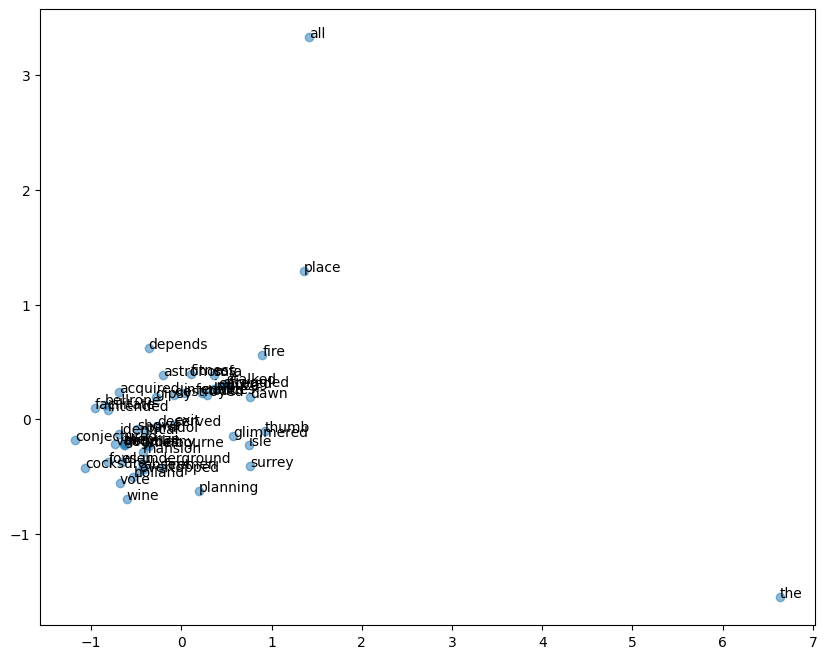

In [262]:
word_list_subset = [vectorize_layer.get_vocabulary()[i] for i in random_indices]

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha = 0.5)

for i, word in enumerate(word_list_subset):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

plt.show()

Now let's draw the graph for the two mentioned pairs.

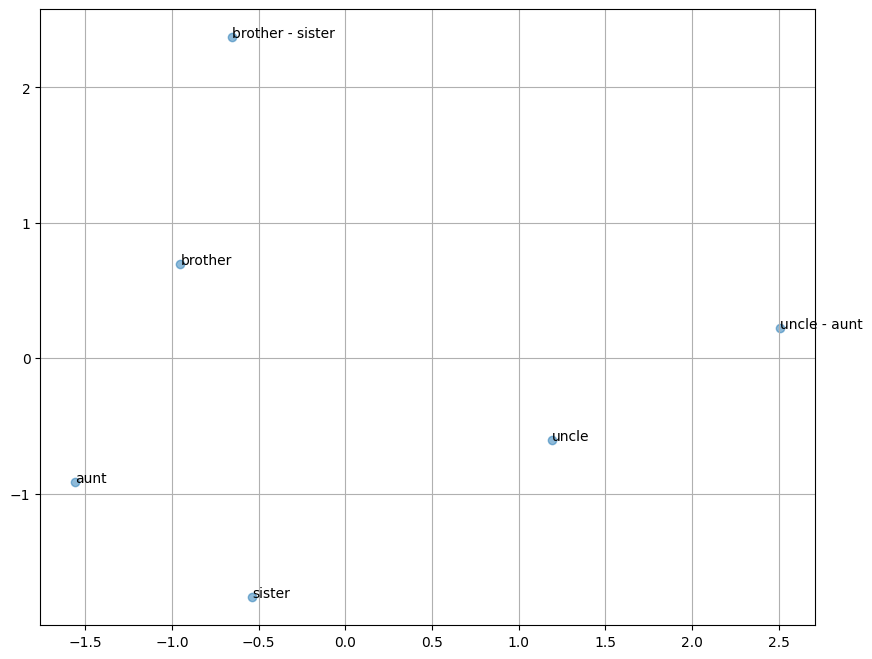

In [263]:
diff_vec_1 = features_embedding[vocab_index['brother']
                                ] - features_embedding[vocab_index['sister']]
diff_vec_2 = features_embedding[vocab_index['uncle']
                                ] - features_embedding[vocab_index['aunt']]

diff_matrix = np.array(
    [
        features_embedding[vocab_index['brother']],
        features_embedding[vocab_index['sister']],
        diff_vec_1,
        features_embedding[vocab_index['uncle']],
        features_embedding[vocab_index['aunt']],
        diff_vec_2
    ]
)

words_list = ['brother', 'sister', 'brother - sister', 'uncle', 'aunt', 'uncle - aunt']

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(diff_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha = 0.5)
plt.grid()

for i, word in enumerate(words_list):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]))

plt.show()